In [1]:
!pip install scikeras
!pip install split-folders # install the package to split the images in TRAIN and TEST folders
!pip install ann_visualizer # visualize NN architectures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=86bdcada408a9691b376da3558e25ad73f5ff1bc819dd54db2f09a2d9a91646a
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


In [33]:
# IMPORT TENSORFLOW/KERAS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

from keras.layers import Input
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.utils import to_categorical
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalMaxPooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# TRANSFER LEARNING
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

# SCIKIT-LEARN/SCIKERAS
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# IMPORT OTHER MODULES
import os
import glob
import datetime

import fnmatch # to count number of image per folder easily
import random # to select random images from a folder
import numpy as np
import pandas as pd
import splitfolders # needed to split the images in TRAIN and TEST folders
from os import mkdir
from pathlib import Path
from shutil import copyfile # to import "copyfile"
import plotly.figure_factory as ff # for printing the heatmap
from collections import defaultdict
from matplotlib import pyplot as plt
import matplotlib.image as img_mat
from sklearn.decomposition import PCA

# CV2
import cv2
from google.colab.patches import cv2_imshow 

In [3]:
# SET RANDOM SEED TO GET, AS MUCH AS POSSIBLE, REPRODUCIBLE RESULTS
# USING NUMPY
from numpy.random import seed
seed(42)

# USING TENSORFLOW: IN ADDITION, TENSORFLOW HAS ITS OWN RANDOM NUMBER
# GENERATOR THAT MUST ALSO BE SEEDED BY CALLING THE SET_RANDOM_SEED()
# FUNCTION IMMEDIATELY AFTER THE NUMPY RANDOM NUMBER GENERATOR
tf.random.set_seed(42)

# USE THE FOLLOWING RESOURCES

**VIDEOS**
- https://www.youtube.com/watch?v=kHtToZidh3A

GITHUB IMPLEMENTATION
- https://github.com/bnsreenu/python_for_microscopists/blob/master/176-multiclass_using_VGG_weights_PCA_NN_RF.py

Copy the notebook TRAINING e aggiungici anche questa parte di PCA all'inizio quando carichi tutte le immagini. Poi ci applichi i modelli. 
APplicare anche il datetime per il clcolo di ogni cella di modello.
Applicare anche quanto visto qua:
- https://shankarmsy.github.io/posts/pca-sklearn.html
- https://towardsdatascience.com/rgb-color-image-compression-using-principal-component-analysis-fce3f48dfdd0
- https://towardsdatascience.com/using-pca-to-reduce-number-of-parameters-in-a-neural-network-by-30x-times-fcc737159282

Unicamente per mostrare l'immagine finale sotto diverse applicazioni della PCA (con 400, 300, 200, 100, 50, 10 dimensioni), con il codice seguente:

In [4]:
# # Visualization of the learning curves
# plt.figure(figsize=(15,6))

# subplot_index = 1
# for n_components in [400, 300, 200, 100, 50, 10]:
    
#     plt.subplot(3, 2, subplot_index)
#     subplot_index = subplot_index + 1

#     ipca = PCA(n_components).fit(img_reshaped)
#     transf_img = ipca.transform(img_reshaped)
#     print("transf_img shape is:", transf_img.shape)

#     print("-----------------------------------")
#     print(f"Explained variances for {n_components}:", np.sum(ipca.explained_variance_ratio_ ) * 100)
#     print("-----------------------------------")

#     # restore the image from the subspace
#     image_restored = ipca.inverse_transform(transf_img)

#     # reshape the image to the original array size
#     image_restored = np.reshape(image_restored, (np.size(img_data, 0),
#                                                  np.size(img_data, 1),
#                                                  np.size(img_data, 2)))
    
#     image_restored = image_restored.astype(np.uint8)
#     # cv2.imwrite(f"/content/{n_components}.jpg", cv2.cvtColor(image_restored, cv2.COLOR_RGB2BGR))

#     plt.axis('off')
#     plt.title('n_components:' + str(n_components))
#     plt.imshow(image_restored)

# plt.show()

In [5]:
# from google.colab import files
# files.download('/content/100.jpg')

-------------------------------------

----------------------

In [4]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# 1.Insert the directory
import sys
sys.path.insert(0,"/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test")

In [6]:
# CONSTANT
# SCALE_PERCENT = 6 # resizing percentage
SEED_VALUE = 42
num_classes = 9 # number of output classes
# SIZE = 224  #Resize images
SIZE = 96  #Resize images

# PATH TO THE DATA
DIR_TRAIN_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/*' # path contenente i sottoinsiemi di train, test
DIR_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/*' # path contenente i sottoinsiemi di train, test
DIR_VAL_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/*' # path contenente i sottoinsiemi di train, test

In [7]:
# Capture training data and labels into respective lists
train_images = []
train_labels = [] 

# GET THE LABELS
for directory_path in glob.glob(DIR_TRAIN_DATA):
    tr_label = directory_path.split("/")[-1]
    print(tr_label)
    # GET THE IMAGES
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(tr_label)

# CONVERT LISTS TO ARRAYS
train_images = np.array(train_images)
train_labels = np.array(train_labels)

################################################################
# CAPTURE TEST/VALIDATION DATA AND LABELS INTO RESPECTIVE LISTS

test_images = []
test_labels = [] 
for directory_path in glob.glob(DIR_TEST_DATA):
    tt_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(tt_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

################################################################
# CAPTURE VALIDATION DATA AND LABELS INTO RESPECTIVE LISTS

val_images = []
val_labels = [] 
for directory_path in glob.glob(DIR_VAL_DATA):
  vv_label = directory_path.split("/")[-1]
  for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.resize(img, (SIZE, SIZE))
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      val_images.append(img)
      val_labels.append(vv_label)

#Convert lists to arrays                
val_images = np.array(val_images)
val_labels = np.array(val_labels)

french_fries
caprese_salad
pizza
greek_salad
sashimi
hot_dog
caesar_salad
hamburger
sushi


In [8]:
print("Length of training images:", len(train_images))
print("Length of training labels:", len(train_labels))
print()
print("Length of training images:", len(test_images))
print("Length of training labels:", len(test_labels))
print()
print("Length of validation images:", len(val_images))
print("Length of validation labels:", len(val_labels))

Length of training images: 1803
Length of training labels: 1803

Length of training images: 155
Length of training labels: 155

Length of validation images: 192
Length of validation labels: 192



---





---



---



In [9]:
#Encode labels from text to integers.

# CREATE THE LABEL ENCODER
le = preprocessing.LabelEncoder()
# FIT
le.fit(val_labels)
# TRANSFORM THE TEST LABELS AND THE TRAIN LABELS
val_labels_encoded = le.transform(val_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_val, y_val = train_images, train_labels_encoded, val_images, val_labels_encoded

###################################################################

# Scale pixel values to between 0 and 1
x_train, x_val = x_train / 255.0, x_val / 255.0 # divide training and validation set

#One hot encode y values for neural network.

y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

### 5.0.1 Model V01 + PCA

In [24]:
# Architecture definition V01
inputs = keras.Input((SIZE, SIZE, 3)) # 224 rows, 224 columns, 3 RGB channels

x = inputs

# 1st Conv layer
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

# 2st Conv layer
x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
# x = keras.layers.GlobalMaxPooling2D()(x)

# # Final dense layer
# outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
outputs = x

net_modelV01_PCA = keras.Model(inputs, outputs)

net_modelV01_PCA.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 activation_4 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 activation_5 (Activation)   (None, 32, 32, 64)        0         
                                                           

In [ ]:
# # FEATURE EXTRACTOR
# # NOW, LET US EXTRACT FEATURES USING VGG IMAGENET WEIGHTS

# # TRAIN FEATURES
# train_feature_extractor = net_modelV01_PCA.predict(x_train)
# train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)
# # TEST FEATURES
# test_feature_extractor = net_modelV01_PCA.predict(x_val)
# test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

# ###########################

# # First verifiy the ideal number of PCA components to not lose much information. 
# # Try to retain 90% information, so look where the curve starts to flatten.
# # Remember that the n_components must be lower than the number of rows or columns (features)
# pca_test = PCA(n_components=64)
# pca_test.fit(train_features)
# plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
# plt.xlabel("Number of components")
# plt.ylabel("Cumulative variance")

In [12]:
# FEATURE EXTRACTOR
# NOW, LET US EXTRACT FEATURES USING VGG IMAGENET WEIGHTS

# TRAIN FEATURES
train_feature_extractor = net_modelV01_PCA.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1) # MEANING OF -1: https://www.codingem.com/numpy-reshape-minus-one/

57/57 [==============================] - 5s 89ms/step


In [18]:
# TEST FEATURES
test_feature_extractor = net_modelV01_PCA.predict(x_val)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

6/6 [==============================] - 1s 84ms/step


In [14]:
train_features.shape

(1803, 65536)

In [19]:
test_features.shape

(192, 65536)

Text(0, 0.5, 'Cumulative variance')

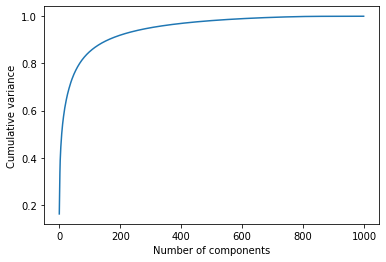

In [17]:
###########################

# First verifiy the ideal number of PCA components to not lose much information. 
# Try to retain 90% information, so look where the curve starts to flatten.
# Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components=1000)
pca_test.fit(train_features)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")

In [20]:
# Pick the optimal number of components. This is how many features we will have 
# for our machine learning
n_PCA_components = 1000
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(train_features)
test_PCA = pca.transform(test_features) # Make sure you are just transforming, not fitting. 

In [23]:
train_PCA.shape

(1803, 1000)

In [48]:
# Architecture definition V01
inputs = keras.Input(shape=(n_PCA_components,))
print(inputs.shape)
x = inputs

# # 1st Conv layer
# x = keras.layers.Dense(1024, activation='softmax')(x)
# x = keras.layers.Conv2D(32, 3, padding='same')(x)
# x = keras.layers.Activation('relu')(x)
# x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

# # # 2st Conv layer
# x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
# x = keras.layers.Activation('relu')(x)
# x = keras.layers.GlobalMaxPooling2D()(x)

# Final dense layer
# x = keras.layers.Dense(1024, activation='softmax')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
# outputs = x

net_modelV01_PCA = keras.Model(inputs, outputs)

net_modelV01_PCA.summary()

(None, 1000)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_20 (Dense)            (None, 9)                 9009      
                                                                 
Total params: 9,009
Trainable params: 9,009
Non-trainable params: 0
_________________________________________________________________


In [49]:
net_modelV01_PCA.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['categorical_accuracy']) # metrics=['accuracy'] # metrics=['categorical_accuracy']

In [50]:
# START COUNTING THE TIME
start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
net_modelV01_PCA.fit(train_PCA, y_train_one_hot, epochs=100, verbose=3)

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

Epoch 87/100
Epoch 88/100
Epoch 89/100
Epoch 90/100
Epoch 91/100
Epoch 92/100
Epoch 93/100
Epoch 94/100
Epoch 95/100
Epoch 96/100
Epoch 97/100
Epoch 98/100
Epoch 99/100
Epoch 100/100
Total execution time with PCA is:  0:00:10.614891


In [51]:
##Predict on test dataset
predict_test = net_modelV01_PCA.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
predict_test = le.inverse_transform(predict_test)
#
#
##Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(val_labels, predict_test))

6/6 [==============================] - 0s 2ms/step
Accuracy =  0.4947916666666667


In [12]:
x_train.shape

(1803, 224, 224, 3)

In [13]:
224*224*3 # total parameters

150528

In [14]:
# #Load VGG model with imagenet trained weights and without classifier/fully connected layers
# #We will use this as feature extractor. 
# # VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
# mobile_net_model = tf.keras.applications.MobileNetV2(weights="imagenet", 
#                                                      include_top=False, 
#                                                      input_shape = (SIZE, SIZE, 3))

# #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
# # for layer in VGG_model.layers:
# # 	layer.trainable = False
    
# mobile_net_model.summary()  #Trainable parameters will be 0

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

### 5.0.1 Model V01 + PCA

6/6 [==============================] - 3s 577ms/step


Text(0, 0.5, 'Cumulative variance')

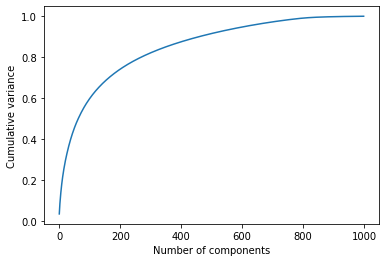

In [15]:
# NOW, LET US EXTRACT FEATURES USING VGG IMAGENET WEIGHTS

# TRAIN FEATURES
train_feature_extractor=mobile_net_model.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)
# TEST FEATURES
test_feature_extractor=mobile_net_model.predict(x_val)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

###########################

# First verifiy the ideal number of PCA components to not lose much information. 
# Try to retain 90% information, so look where the curve starts to flatten.
# Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components=1000)
pca_test.fit(train_features)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")

In [16]:
# Pick the optimal number of components. This is how many features we will have 
# for our machine learning
n_PCA_components = 1000
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(train_features)
test_PCA = pca.transform(test_features) # Make sure you are just transforming, not fitting. 

#If we want 90% information captured we can also try ...
#pca=PCA(0.9)
#principalComponents = pca.fit_transform(X_for_RF)

In [17]:
from tensorflow.keras import Model
############## Neural Network Approach ##################

##Add hidden dense layers and final output/classifier layer.
model = Sequential()
inputs = Input(shape=(n_PCA_components,)) #Shape = n_components
hidden = Dense(256, activation='relu')(inputs)
#hidden1 = Dense(512, activation='relu')(inputs)
#hidden2 = Dense(256, activation='relu')(hidden1)
output = Dense(9, activation='softmax')(hidden)
model = Model(inputs=inputs, outputs=output)

print(model.summary())
#
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['categorical_accuracy']) # metrics=['accuracy'] # metrics=['categorical_accuracy']

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 258,569
Trainable params: 258,569
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import datetime
start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
model.fit(train_PCA, y_train_one_hot, epochs=500, verbose=3)

end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

# EVALUATION

In [19]:
##Predict on test dataset
predict_test = model.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
predict_test = le.inverse_transform(predict_test)
#
#
##Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(val_labels, predict_test))

6/6 [==============================] - 0s 2ms/step
Accuracy =  0.84375


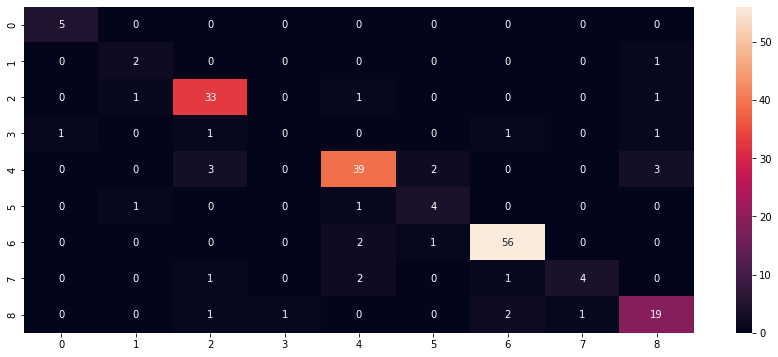

In [20]:
#Confusion Matrix - verify accuracy of each class
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualization of the learning curves
plt.figure(figsize=(15,6))

cm = confusion_matrix(val_labels, predict_test)
#print(cm)
sns.heatmap(cm, annot=True)

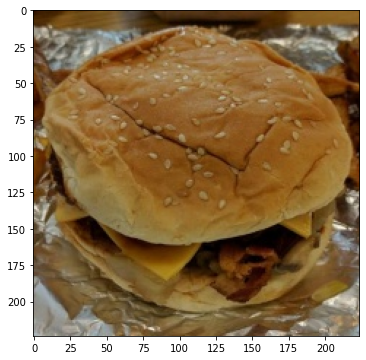

In [30]:
# Visualization of the learning curves
plt.figure(figsize=(15,6))

#Check results on a few select images
n=np.random.randint(0, x_val.shape[0])
img = x_val[n]
plt.imshow(img)

In [31]:
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature = mobile_net_model.predict(input_img)
input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
input_img_PCA = pca.transform(input_img_features)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
print("The actual label for this image is: ", val_labels[n])

1/1 [==============================] - 0s 15ms/step
The prediction for this image is:  ['hamburger']
The actual label for this image is:  hamburger
